# Gaussian Processes Regression

## Implementation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

from itertools import islice
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
class GPR:
    def __init__(self) -> None:
        constrain_positive = GPR.constrain_positive()

        self._kernel, variables = GPR.kernel(constrain_positive)
        self._noise = GPR.noise(constrain_positive)
        self._trainable_variables = [v.variables[0] for v in variables + [self._noise]]

        self._mean = None
        self._mean_fun = lambda _: self._mean

    def fit(self, X, Y, lr: float = 0.001, batch_size: int = 128, num_iterations: int = 11000):
        self._X_train = X
        self._Y_train = Y

        self._mean = GPR.mean(Y)

        # legacy Adam works two times faster on my computer
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

        dataset = (
            tf.data.Dataset.from_tensor_slices((X, Y))
            .shuffle(buffer_size=len(Y))
            .repeat(count=None)
            .batch(batch_size)
        )

        batch_ll = {}
        full_ll = {}

        for i, (X_batch, Y_batch) in tqdm(
            enumerate(islice(dataset, num_iterations)), 
            total=num_iterations
        ):
            with tf.GradientTape() as tape:
                loss = self.loss(X_batch, Y_batch)

            grads = tape.gradient(loss, self._trainable_variables)
            optimizer.apply_gradients(zip(grads, self._trainable_variables))
            batch_ll[i] = loss.numpy()

            if i % 100 == 0:
                full_ll[i] = self.loss(X, Y).numpy()

        return batch_ll, full_ll

    def predict(self, X):
        posterior_predict = tfp.distributions.GaussianProcessRegressionModel(
            mean_fn=self._mean_fun,
            kernel=self._kernel,
            index_points=X,
            observation_index_points=self._X_train,
            observations=self._Y_train,
            observation_noise_variance=self._noise
        )

        posterior_mean_predict = posterior_predict.mean()
        posterior_std_predict = posterior_predict.stddev()

        return posterior_mean_predict, posterior_std_predict
    
    @tf.function(autograph=False, experimental_compile=False)
    def loss(self, X, Y):
        gp = tfp.distributions.GaussianProcess(
            mean_fn=self._mean_fun,
            kernel=self._kernel,
            index_points=X,
            observation_noise_variance=self._noise
        )
        
        negative_log_likelihood = -gp.log_prob(Y)

        return negative_log_likelihood

    @staticmethod
    def constrain_positive():
        return tfp.bijectors.Shift(np.finfo(np.float64).tiny)(tfp.bijectors.Exp())

    @staticmethod
    def kernel(constrain_positive):
        # exponential quadric
        smooth_amplitude = tfp.util.TransformedVariable(
            initial_value=10.0,
            bijector=constrain_positive,
            dtype=np.float64,
            name="smooth_amplitude",
        )

        smooth_length_scale = tfp.util.TransformedVariable(
            initial_value=10.0,
            bijector=constrain_positive,
            dtype=np.float64,
            name="smooth_length_scale",
        )

        smooth_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=smooth_amplitude, length_scale=smooth_length_scale
        )

        # local periodic
        periodic_amplitude = tfp.util.TransformedVariable(
            initial_value=5.0,
            bijector=constrain_positive,
            dtype=np.float64,
            name="periodic_amplitude",
        )

        periodic_length_scale = tfp.util.TransformedVariable(
            initial_value=1.0,
            bijector=constrain_positive,
            dtype=np.float64,
            name="periodic_length_scale",
        )

        periodic_period = tfp.util.TransformedVariable(
            initial_value=1.0,
            bijector=constrain_positive,
            dtype=np.float64,
            name="periodic_period",
        )

        periodic_local_length_scale = tfp.util.TransformedVariable(
            initial_value=1.0,
            bijector=constrain_positive,
            dtype=np.float64,
            name="periodic_local_length_scale",
        )

        local_periodic_kernel = tfp.math.psd_kernels.ExpSinSquared(
            amplitude=periodic_amplitude,
            length_scale=periodic_length_scale,
            period=periodic_period,
        ) * tfp.math.psd_kernels.ExponentiatedQuadratic(
            length_scale=periodic_local_length_scale
        )

        # rational quadric
        irregular_amplitude = tfp.util.TransformedVariable(
            initial_value=1.0,
            bijector=constrain_positive,
            dtype=np.float64,
            name="irregular_amplitude",
        )

        irregular_length_scale = tfp.util.TransformedVariable(
            initial_value=1.0,
            bijector=constrain_positive,
            dtype=np.float64,
            name="irregular_length_scale",
        )

        irregular_scale_mixture = tfp.util.TransformedVariable(
            initial_value=1.0,
            bijector=constrain_positive,
            dtype=np.float64,
            name="irregular_scale_mixture",
        )

        irregular_kernel = tfp.math.psd_kernels.RationalQuadratic(
            amplitude=irregular_amplitude,
            length_scale=irregular_length_scale,
            scale_mixture_rate=irregular_scale_mixture,
        )

        # final kernel
        kernel = smooth_kernel + local_periodic_kernel + irregular_kernel

        # trainable variables
        variables = [
            smooth_amplitude,
            smooth_length_scale,
            periodic_amplitude,
            periodic_length_scale,
            periodic_period,
            periodic_local_length_scale,
            irregular_amplitude,
            irregular_length_scale,
            irregular_scale_mixture,
        ]

        return kernel, variables

    @staticmethod
    def noise(constrain_positive):
        return tfp.util.TransformedVariable(
            initial_value=1,
            bijector=constrain_positive,
            dtype=np.float64,
            name="observation_noise_variance",
        )
    
    @staticmethod
    def mean(X: np.ndarray):
        return tf.constant([np.mean(X)], dtype=tf.float64)


Instructions for updating:
experimental_compile is deprecated, use jit_compile instead


## GPR for CO_2 concentration

### Prepare data

In [3]:
co2_df = pd.read_csv(
    "./data/monthly_in_situ_co2_mlo2.csv", 
    usecols=[3, 4], 
    dtype=np.float64,
    na_values='-99.99',
).dropna().rename(columns=lambda c: c.strip())

co2_df.head()

,Date,CO2
2,1958.2027,315.70
3,1958.2877,317.45
4,1958.3699,317.51
6,1958.5370,315.86
7,1958.6219,314.93


### Visualize data

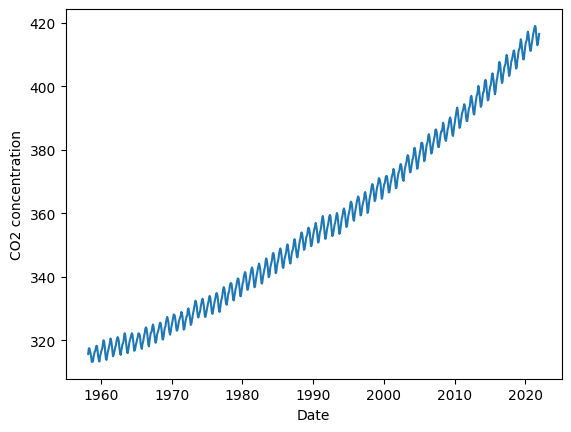

In [4]:
plt.plot(co2_df["Date"], co2_df["CO2"])
plt.xlabel("Date")
plt.ylabel("CO2 concentration")
plt.show()

### Train test split

In [5]:
co2_df_train = co2_df[co2_df["Date"] < 2012]
co2_df_test = co2_df[co2_df["Date"] >= 2012]

### Training

In [6]:
co2_gpr = GPR()

co2_batch_ll, co2_full_ll = co2_gpr.fit(
    co2_df_train["Date"].values.reshape(-1, 1), 
    co2_df_train["CO2"].values,
)

  0%|          | 0/11000 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


100%|██████████| 11000/11000 [01:00<00:00, 181.73it/s]


### Visualization

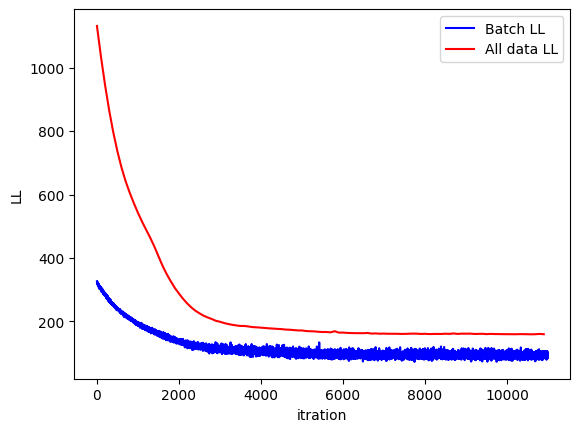

In [7]:
plt.plot(list(co2_batch_ll.keys()), list(co2_batch_ll.values()), color="blue")
plt.plot(list(co2_full_ll.keys()), list(co2_full_ll.values()), color="red")
plt.legend(["Batch LL", "All data LL"])
plt.xlabel("itration")
plt.ylabel("LL")
plt.show()

### Training variables

In [8]:
pd.DataFrame(
    columns=["Name", "Value"], 
    data=[(v.name[:-2], v.numpy()) for v in co2_gpr._trainable_variables]
).set_index("Name")

,Value
Name,
smooth_amplitude,4.840462
smooth_length_scale,4.598245
periodic_amplitude,1.143071
periodic_length_scale,0.516595
periodic_period,0.000406
periodic_local_length_scale,4.765727
irregular_amplitude,0.051091
irregular_length_scale,0.334515
irregular_scale_mixture,-2.396733


### Predictions

In [9]:
mean, std = co2_gpr.predict(co2_df_test["Date"].values.reshape(-1, 1))

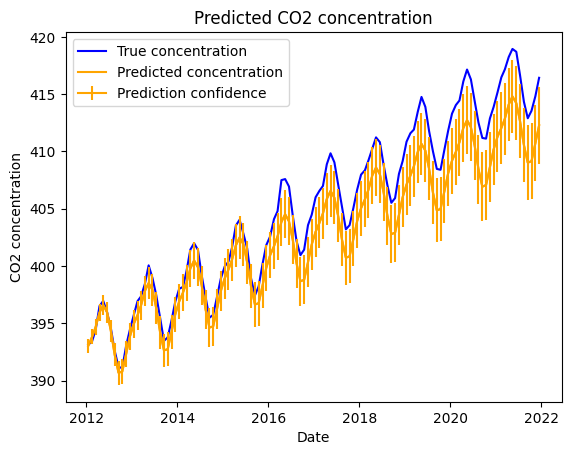

In [10]:
plt.plot(co2_df_test["Date"], co2_df_test["CO2"], color="blue")
plt.plot(co2_df_test["Date"], mean, color="orange")
plt.errorbar(co2_df_test["Date"], mean, yerr=std*2, color="orange")
plt.xlabel("Date")
plt.ylabel("CO2 concentration")
plt.title("Predicted CO2 concentration")
plt.legend(["True concentration", "Predicted concentration", "Prediction confidence"])
plt.show()

The true prediction values ​​are within the confidence interval until 2016. Since then, the predictions have been underestimated - the dynamics of CO2 concentration growth is growing faster and faster - such a dependence probably did not occur in the training set or was much smaller.